# Practica 6.2. Redes Recurrentes

In [1]:
import keras
keras.__version__

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

'2.2.4'

## 1. Una primera capa recurrente en Keras

Keras proporciona una capa recurrente muy simple, sin ningún tipo de aditivos ni mejoras: la capa `SimpleRNN`.


In [2]:
from keras.layers import SimpleRNN

Como el resto de capas de Keras, `SimpleRNN` procesa batches de secuencias, lo que quiere decir que toma como entrada algo de la forma `(batch_size, timesteps, input_features)`.

Esta capa tiene dos modos de ejecución. Para cada secuencia de entrada puede: devolver la última salida del procesamiento de la secuencia de entrada (un tensor de tamaño `(batch_size, output_features)`), o bien devolver la secuencia completa de salidas (un tensor de tamaño `(batch_size, timesteps, output_features)`). La elección de estos dos modos se hace por medio del argumento `return_sequences`:

In [3]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [4]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


Estas capas se pueden apilar como cualquier otra de Keras (teniendo en cuenta que, para que colapsen, ha de usarse el modo de devolución de secuencias completas):

In [5]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # Esta última capa solo devuelve las últimas salidas.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Probemos cómo se comporta esta capa en el ejemplo de clasificación de opiniones de IMDB. Primero, debemos comenzar preprocesando los datos:

In [7]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # número de palabras a considerar como características
maxlen = 500  # cortar textos después de este número de palabras (entre las características máximas más comunes)
batch_size = 32


# Descomenta las siguientes líneas y la última de la celda en caso de obtener el error "Object arrays cannot be loaded when allow_pickle=False"
#import numpy as np
#np_load_old = np.load
#np.load = lambda *a, **k: np_load_old(*a, allow_pickle=True, **k)

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

#np.load = np_load_old

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Ahora entrenemos una red en la que hemos añadido una capa `Embedding` y otra `SimpleRNN`:

In [8]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 13s 635us/step - loss: 0.6438 - acc: 0.6123 - val_loss: 0.5082 - val_acc: 0.7676
Epoch 2/10
20000/20000 [==============================] - 12s 591us/step - loss: 0.4476 - acc: 0.8066 - val_loss: 0.4151 - val_acc: 0.8210
Epoch 3/10
20000/20000 [==============================] - 12s 584us/step - loss: 0.3102 - acc: 0.8759 - val_loss: 0.3563 - val_acc: 0.8588
Epoch 4/10
20000/20000 [==============================] - 12s 590us/step - loss: 0.2451 - acc: 0.9034 - val_loss: 0.3998 - val_acc: 0.8398
Epoch 5/10
20000/20000 [==============================] - 12s 584us/step - loss: 0.1843 - acc: 0.9299 - val_loss: 0.3892 - val_acc: 0.8614
Epoch 6/10
20000/20000 [==============================] - 12s 590us/step - loss: 0.1297 - acc: 0.9539 - val_loss: 0.3806 - val_acc: 0.8712
Epoch 7/10
20000/20000 [==============================] - 12s 589us/s

Y mostremos cómo se ha comportado el entrenamiento:

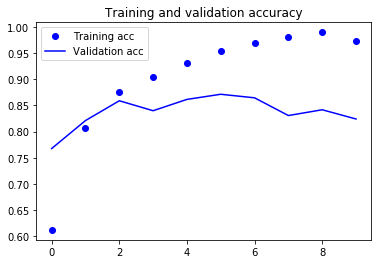

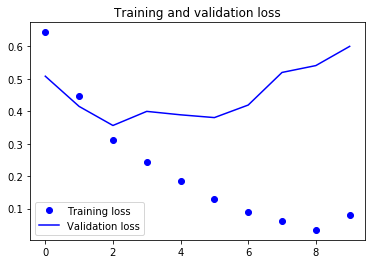

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Vemos que muy pronto se produce un sobreajuste y nos quedamos por debajo del 88% conseguido por el método directo de las capas densas visto en un ejemplo anterior. Parte del problema, por supuesto, es que ahora las entradas solo consideran las primeras 500 palabras, y no la secuencia completa, pero además la capa `SimpleRNN` no es suficientemente buena para procesar secuencias largas, ya que sufre el problema del **desvanecimiento del gradiente** habitual en capas profundas, lo que significa que apenas puede recordar estados que estén muy atrás en el tiempo. 

A continuación veremos otros modelos recurrentes que intentan evitar este problema.

## 2. Un ejemplo de LSTM en Keras

Vamos a abordar el mismo problema de antes pero sustituyendo la capa `SimpleRNN` por una capa LSTM. Aunque esta nueva capa tiene muchos argumentos, dejaremos por defecto los que trae Keras (que no funcionan mal) y solo ajustaremos la dimensión de salida :

In [11]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 54s 3ms/step - loss: 0.5102 - acc: 0.7615 - val_loss: 0.3754 - val_acc: 0.8390
Epoch 2/10
20000/20000 [==============================] - 54s 3ms/step - loss: 0.2919 - acc: 0.8862 - val_loss: 0.3589 - val_acc: 0.8388
Epoch 3/10
20000/20000 [==============================] - 54s 3ms/step - loss: 0.2349 - acc: 0.9092 - val_loss: 0.2878 - val_acc: 0.8858
Epoch 4/10
20000/20000 [==============================] - 54s 3ms/step - loss: 0.1942 - acc: 0.9272 - val_loss: 0.2937 - val_acc: 0.8718
Epoch 5/10
20000/20000 [==============================] - 54s 3ms/step - loss: 0.1753 - acc: 0.9358 - val_loss: 0.3847 - val_acc: 0.8786
Epoch 6/10
20000/20000 [==============================] - 54s 3ms/step - loss: 0.1549 - acc: 0.9425 - val_loss: 0.3795 - val_acc: 0.8624
Epoch 7/10
20000/20000 [==============================] - 54s 3ms/step - loss: 0.1432 - acc: 0.9491 - val_loss: 0.3858 - val_acc:

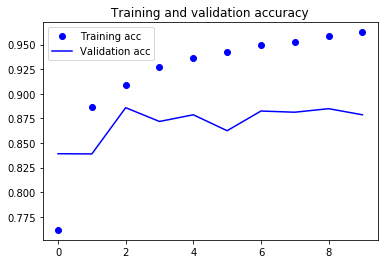

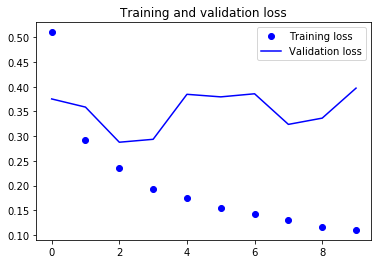

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Alcanzamos un 88% de accuracy, que supera el de la red con `SimpleRNN` ya que LSTM sufre menos el efecto del desvanecimiento, y aproximadamente igual (quizás un poco mejor) que el de la red densa (que había recibido más información sobre cada opinión). 

Sin embargo, esta solución con LSTM requiere mucha más potencia computacional que la densa, y los resultados no son tan llamativos. Por supuesto, una razón puede ser que no hemos hecho ningún ajuste fino de los parámetros de la red (por ejemplo, la dimensión de inmersión), por lo que quizás no estamos obteniendo el rendimiento que podíamos. Pero quizás la razón principal es que analizar la estructura completa de las opiniones quizás no sea tan importante para evaluar un problema de análisis de sentimientos, y quizás solo sea suficiente con saber qué palabras, y con qué frecuencia, aparecen en la opinión.

Pero hay problemas mucho más duros que este para los que las redes densas no proporcionarían una solución suficientemente buena, y para los que las LSTM sí funcionan bien, como, por ejemplo, la traducción automática.